<a href="https://colab.research.google.com/github/diwanliwe/topout/blob/master/Topout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
os.path.isfile("/content/drive/My Drive/ShapeData/tf_utils.py")

True

In [ ]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#from kt_utils import *
from keras import optimizers

import keras.backend as K
from keras.models import Model
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import math
import json
import numpy as np
from random import *
import random as rnd
import tensorflow as tf
from tensorflow.python.framework import ops
#from google.colab import files
#uploaded = files.upload()
#from tf_utils.py import load_dataset, random_mini_batches, convert_to_one_hot, predict

Using TensorFlow backend.


In [ ]:
import h5py
import numpy as np
import tensorflow as tf
import math

def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)

    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.

    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """

    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)

    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y


def predict(X, parameters):

    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])

    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}

    x = tf.placeholder("float", [12288, 1])

    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)

    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})

    return prediction

def forward_propagation_for_predict(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX

    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters
    Returns:
    Z3 -- the output of the last LINEAR unit
    """

    # Retrieve the parameters from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3

    return Z3

## Raw Data from Moon Board sample by Human

#### Moon17 - Type Matrix
* 0 : Jug
* 1 : Micro Jug
* 2 : Pinch
* 3 : Pocket
* 4 : Crimp
* 5 : Slopper

#### MoonOr17 - Orientation Matrix
* 0 : No orientation
* 1 : 0 degree
* 2 : 22.5 degree
* 3 : 45 degree
* 4 : 67.5 degree
* 5 : 90 degree
* 6 : 112.5 degree
* 7 : 135 degree
* 8 : 157.5 degree

#### Moontext17 - Texture Matrix
* 0 : Resine
* 1 : Wood


In [ ]:
Moon17=np.array([[1, 4, 4, 1, 3, 1, 1, 4, 1, 2, 2],
                 [1, 0, 4, 0, 4, 1, 4, 4, 0, 1, 1],
                 [0, 0, 4, 4, 0, 4, 4, 3, 3, 4, 4],
                 [1, 0, 0, 0, 3, 0, 2, 1, 4, 4, 5],
                 [0, 4, 4, 1, 5, 0, 5, 0, 4, 4, 1],
                 [0, 4, 4, 4, 4, 1, 2, 4, 4, 4, 4],
                 [2, 1, 0, 3, 0, 2, 3, 3, 0, 2, 2],
                 [1, 2, 4, 5, 0, 0, 2, 1, 0, 4, 4],
                 [4, 2, 4, 0, 4, 0, 2, 2, 4, 0, 2],
                 [4, 2, 0, 0, 5, 4, 0, 0, 2, 4, 4],
                 [1, 2, 4, 4, 2, 4, 0, 2, 4, 0, 0],
                 [1, 2, 1, 2, 1, 2, 1, 4, 2, 2, 4],
                 [4, 0, 0, 4, 0, 1, 2, 4, 1, 2, 1],
                 [0, 2, 1, 4, 1, 4, 4, 1, 4, 5, 4],
                 [4, 4, 4, 0, 4, 2, 4, 4, 2, 2, 0],
                 [4, 4, 0, 1, 1, 4, 4, 4, 1, 0, 4],
                 [5, 4, 4, 1, 5, 1, 1, 4, 4, 5, 4],
                 [0, 0, 2, 0, 1, 0, 4, 0, 2, 0, 4]])
Moon17 = Moon17+1

MoonOr17= np.array([[6,4,5,5,5,5,5,4,6,5,5],
                    [5,7,1,8,5,5,5,5,4,3,5],
                    [1,6,1,4,5,4,1,4,4,2,5],
                    [4,0,0,8,6,1,1,4,2,1,2],
                    [8,8,1,7,1,1,1,3,4,2,2],
                    [1,1,8,1,1,8,8,1,2,1,1],
                    [8,1,1,0,1,1,0,0,1,2,2],
                    [8,8,2,1,2,1,2,2,2,1,1],
                    [1,1,8,8,8,1,2,1,2,2,2],
                    [8,8,1,8,1,1,2,0,2,2,2],
                    [2,7,1,8,2,1,8,8,1,2,1],
                    [1,8,6,8,1,1,1,1,1,2,1],
                    [1,1,8,1,1,1,2,1,4,2,2],
                    [1,1,8,1,2,1,1,1,1,1,2],
                    [1,8,8,1,8,2,2,1,1,2,0],
                    [2,1,2,8,1,1,8,2,8,1,2],
                    [7,1,8,1,1,1,1,1,1,1,2],
                    [8,1,1,1,1,1,1,1,1,1,1]])

MoonTex17= np.array([[0,0,0,0,0,0,0,0,0,0,0],
                    [0,0,0,0,0,0,0,0,0,0,0],
                    [0,0,0,0,0,0,0,0,0,0,0],
                    [0,0,0,0,0,0,0,0,0,0,0],
                    [0,1,0,0,1,0,1,0,0,1,0],
                    [0,0,1,0,0,0,0,0,1,0,0],
                    [1,0,0,1,0,0,0,1,0,0,1],
                    [0,0,0,0,0,0,0,0,0,0,0],
                    [0,0,1,0,1,0,1,0,1,0,0],
                    [1,0,0,0,0,0,0,0,0,0,1],
                    [0,0,1,0,0,0,0,0,1,0,0],
                    [0,1,0,0,1,0,1,0,0,1,0],
                    [0,0,0,1,0,0,0,1,0,0,0],
                    [0,0,0,0,0,0,0,0,0,0,0],
                    [0,1,0,0,1,0,1,0,0,1,0],
                    [0,0,0,1,0,0,0,1,0,0,0],
                    [0,0,0,0,0,0,0,0,0,0,0],
                    [0,0,1,0,0,0,0,0,1,0,0]])


Grade need to be symetric


Miror take a Problem matrix M (Role/Type/orientation) and return the miror Problem matrix

In [ ]:
def Miror(M):
    (n,m,k) = M.shape
    Miror = np.zeros((n,m,k))
    for j in range(m):
        for i in range(n):
            Miror[i][j] = M[i][m-j-1]
            Orientation = M[i][j][2]
            if Orientation == 2 :
                Miror[a][b][2] = 8/8
            if Orientation == 3 :
                Miror[a][b][2] = 7/8
            if Orientation == 4 :
                Miror[a][b][2] = 6/8
            if Orientation == 6 :
                Miror[a][b][2] = 4/8
            if Orientation == 7 :
                Miror[a][b][2] = 3/8
            if Orientation == 8 :
                Miror[a][b][2] = 2/8
    return Miror

Import data from Json to Python list

S4: 4 grades Scale (6A&-/6B/6C/7A&+)

S5: 5 grades Scale (6A&-/6B/6C/7A/7B&+)

Distrib count the number of problems for each Grade


In [ ]:
# 5 category (6a&-/6b/6c/7a/7b&+)
def CreateDataS5(file):
    jsonFile = open(file, "r") # Open the JSON file for reading
    data = json.load(jsonFile) # Read the JSON into the buffer
    data = data["Data"]
    jsonFile.close() # Close the JSON file

    n = len(data)
    Lx=[]
    #Lr=[]
    Ly=[]
    for i in range(n):
        p = data[i]
        x = np.zeros((18, 11), dtype=np.uint8)
        if p['Grade'] != '8B' and p["Relief"] != '25' and p["Repeats"]>-1:
            for m in p["Moves"]:
                if m['IsStart']:
                    x[m['Y']-1][m['X']-1]=1
                elif m['IsEnd']:
                    x[m['Y']-1][m['X']-1]=3
                else:
                    x[m['Y']-1][m['X']-1]=2
            g = p['Grade']
            y = 4
            if g == '6A' or g =='6A+':
                y = 0
            elif g == '6B' or g =='6B+':
                y = 1
            elif g =='6C' or g =='6C+':
                y = 2
            elif g =='7A' or g =='7A+':
                y = 3
            Lx += [x]
            Ly += [y]
            acc=0
            """
            for a in range(18):
                for b in range(11):
                    if x[a][b]==wtf[a][b]:
                        acc +=1
            if acc ==198:
                print(p)
            #Lr += [p["Relief"]]
            #"""
    return (Lx,Ly)

def CreateDatamaxS5(file):
    jsonFile = open(file, "r") # Open the JSON file for reading
    data = json.load(jsonFile) # Read the JSON into the buffer
    data = data["Data"]
    jsonFile.close() # Close the JSON file

    n = len(data)
    Lx=[]
    #Lr=[]
    Ly=[]
    for i in range(n):
        p = data[i]
        x = np.zeros((18, 11), dtype=np.uint8)
        if p['Grade'] != '8B' and p["Relief"] != '25' and p["Repeats"]>-1:
            for m in p["Moves"]:
                if m['IsStart']:
                    x[m['Y']-1][m['X']-1]=1
                elif m['IsEnd']:
                    x[m['Y']-1][m['X']-1]=3
                else:
                    x[m['Y']-1][m['X']-1]=2
            g = p['Grade']
            y = 4
            if g == '6A' or g =='6A+':
                y = 0
            elif g == '6B' or g =='6B+':
                y = 1
            elif g =='6C' or g =='6C+':
                y = 2
            elif g =='7A' or g =='7A+':
                y = 3
            if (y == 0 and p["Repeats"]>27) or (y == 1 and p["Repeats"]>15) or (y == 2 and p["Repeats"]>10) or  (y == 3 and p["Repeats"]>8)  or (y == 4):
              Lx += [x]
              Ly += [y]
              acc=0
            """
            for a in range(18):
                for b in range(11):
                    if x[a][b]==wtf[a][b]:
                        acc +=1
            if acc ==198:
                print(p)
            #Lr += [p["Relief"]]
            #"""
    return (Lx,Ly)

# 4 category (6a&-/6b/6c/7a&+)
def CreateDataS4(file):
    jsonFile = open(file, "r") # Open the JSON file for reading
    data = json.load(jsonFile) # Read the JSON into the buffer
    data = data["Data"]
    jsonFile.close() # Close the JSON file

    n = len(data)
    Lx=[]
    #Lr=[]
    Ly=[]
    for i in range(n):
        p = data[i]
        x = np.zeros((18, 11), dtype=np.uint8)
        if p['Grade'] != '8B' and p['Grade'] != '8B' and p['Grade'] != '8A+' and p['Grade'] != '8A ' and p['Grade'] != '7C' and p['Grade'] != '7C+' and p['Grade'] != '7B' and p['Grade'] != '7B+' and p["Relief"] != '25':
            for m in p["Moves"]:
                if m['IsStart']:
                    x[m['Y']-1][m['X']-1]=1
                elif m['IsEnd']:
                    x[m['Y']-1][m['X']-1]=3
                else:
                    x[m['Y']-1][m['X']-1]=2
            g = p['Grade']
            y = 3
            if g == '6A' or g =='6A+':
                y = 0
            elif g == '6B' or g =='6B+':
                y = 1
            elif g =='6C' or g =='6C+':
                y = 2
            Lx += [x]
            Ly += [y]
            #Lr += [p["Relief"]]
    return (Lx,Ly)

def Load_Data(Lx,Ly):
    #n_x = len(Lx)
    #n_y = len(Ly)
    X_train = np.zeros((8192*2,2,18,11))
    Y_train = np.zeros((1,8192*2), dtype=np.uint8)
    X_test = np.zeros((2048*2,2,18,11))
    Y_test = np.zeros((1,2048*2), dtype=np.uint8)
    for i in range(8192*2):
        X_train[i][0] = Lx[i]
        X_train[i][0] = X_train[i][0]/3
        X_train[i][1] = Moon17
        X_train[i][1] = X_train[i][1]/5
        Y_train[0][i] = int(Ly[i])
    for i in range(2048*2):
        X_test[i][0] = Lx[i+8192*2]
        X_test[i][0] = X_test[i][0]/3
        X_test[i][1] = Moon17
        X_test[i][1] = X_test[i][1]/5
        Y_test[0][i] = int(Ly[i+8192*2])
    return (X_train,Y_train,X_test,Y_test)


def Distrib(L):
    compt = np.zeros((6))
    n = len(L)
    for i in range(n):
        compt[L[i]] +=1
    return compt

Lx=[]
Ly=[]
Lr=[]
for i in range(1,51):
    a,b= CreateDataS5('/content/drive/My Drive/ShapeData/J'+str(i)+'.TXT')
    Lx+=a
    Ly+=b
d = Distrib(Ly)
print(d)
print(np.sum(d))

[5726. 5125. 4396. 4395. 2417.    0.]
22059.0


Load Data function from differente shape

Load_Data_imgS5: Presence

Load_Data_TypeS5: Presence/Type

Load_Data_OrS5: Presence/Type/Orientation

Load_Data_AllS5: Presence/Type/Orientation/Texture

All Grades categorie have the same number of problems picked randomly from Data


In [ ]:
def Load_Data_imgS5(n_train,n_test):
    #create Data
    Lx=[]
    Ly=[]
    for i in range(1,51):
        a,b = CreateDataS5('J'+str(i)+'.TXT')
        Lx+=a
        Ly+=b
    #create a list order by difficulty
    n = len(Lx)
    S = [[]]*5
    for i in range (n):
        S[Ly[i]] = S[Ly[i]] + [(Lx[i],Ly[i])]
    for j in range(5):
        rnd.shuffle(S[j])
    #Create a shuffle data set with even distribution of difficulty
    l = n_train+n_test
    data = [[]]*(l*5)
    for k in range(l):
        data[k] = S[0][k]
        data[k + l] = S[1][k]
        data[k + 2*l] = S[2][k]
        data[k + 3*l] = S[3][k]
        data[k + 4*l] = S[4][k]
    rnd.shuffle(data)
    #Create Train and test set
    X_train = np.zeros((5*n_train,18,11))
    Y_train = np.zeros((1,5*n_train), dtype=np.uint8)
    X_test = np.zeros((5*n_test,18,11))
    Y_test = np.zeros((1,5*n_test), dtype=np.uint8)
    for i in range(5*n_train):
        X_train[i] = data[i][0]
        X_train[i] = X_train[i]/3
        Y_train[0][i] = int(data[i][1])
    for i in range(5*n_test):
        X_test[i] = data[i+5*n_train][0]
        X_test[i] = X_test[i][0]/3
        Y_test[0][i] = int(data[i+5*n_train][1])
    return (X_train,Y_train,X_test,Y_test)

def Load_Data_TypeS5(n_train,n_test):
    #create Data
    Lx=[]
    Ly=[]
    for i in range(1,51):
        a,b = CreateDataS5('J'+str(i)+'.txt')
        Lx+=a
        Ly+=b
    #create a list order by difficulty
    n = len(Lx)
    S = [[]]*5
    for i in range (n):
        S[Ly[i]] = S[Ly[i]] + [(Lx[i],Ly[i])]
    for j in range(5):
        rnd.shuffle(S[j])
    #Create a shuffle data set with even distribution of difficulty
    l = n_train+n_test
    data = [[]]*(l*5)
    for k in range(l):
        data[k] = S[0][k]
        data[k + l] = S[1][k]
        data[k + 2*l] = S[2][k]
        data[k + 3*l] = S[3][k]
        data[k + 4*l] = S[4][k]
    rnd.shuffle(data)
    #Create Train and test set
    X_train = np.zeros((5*n_train,18,11,2))
    Y_train = np.zeros((1,5*n_train), dtype=np.uint8)
    X_test = np.zeros((5*n_test,18,11,2))
    Y_test = np.zeros((1,5*n_test), dtype=np.uint8)
    for i in range(5*n_train):
        pres = np.multiply(((data[i][0])>0),Moon17)
        for k in range(18):
            for l in range(11):
                X_train[i][k][l][0] = (data[i][0][k][l])/3
                X_train[i][k][l][1] = (pres[k][l])/8
        Y_train[0][i] = int(data[i][1])
    for i in range(5*n_test):
        pres = np.multiply(((data[i+5*n_train][0])>0),Moon17)
        for k in range(18):
            for l in range(11):
                X_test[i][k][l][0] = (data[i+5*n_train][0][k][l])/3
                X_test[i][k][l][1] = (pres[k][l])/8
        Y_test[0][i] = int(data[i+5*n_train][1])
    return (X_train,Y_train,X_test,Y_test)

def Load_Data_OrS5(n_train,n_test):
    #create Data
    Lx=[]
    Ly=[]
    for i in range(1,51):
        a,b = CreateDataS5('J'+str(i)+'.txt')
        Lx+=a
        Ly+=b
    #create a list order by difficulty
    n = len(Lx)
    S = [[]]*5
    for i in range (n):
        S[Ly[i]] = S[Ly[i]] + [(Lx[i],Ly[i])]
    for j in range(5):
        rnd.shuffle(S[j])
    #Create a shuffle data set with even distribution of difficulty
    l = n_train+n_test
    data = [[]]*(l*5)
    for k in range(l):
        data[k] = S[0][k]
        data[k + l] = S[1][k]
        data[k + 2*l] = S[2][k]
        data[k + 3*l] = S[3][k]
        data[k + 4*l] = S[4][k]
    rnd.shuffle(data)
    #Create Train and test set
    X_train = np.zeros((5*n_train,18,11,3))
    Y_train = np.zeros((1,5*n_train), dtype=np.uint8)
    X_test = np.zeros((5*n_test,18,11,3))
    Y_test = np.zeros((1,5*n_test), dtype=np.uint8)
    for i in range(5*n_train):
        pres = np.multiply(((data[i][0])>0),Moon17)
        orientation = np.multiply(((data[i][0])>0),MoonOr17)
        for k in range(18):
            for l in range(11):
                X_train[i][k][l][0] = (data[i][0][k][l])/3
                X_train[i][k][l][1] = (pres[k][l])/6
                X_train[i][k][l][2] = (orientation[k][l])/8
        Y_train[0][i] = int(data[i][1])
    for i in range(5*n_test):
        pres = np.multiply(((data[i+5*n_train][0])>0),Moon17)
        orientation = np.multiply(((data[i+5*n_train][0])>0),MoonOr17)
        for k in range(18):
            for l in range(11):
                X_test[i][k][l][0] = (data[i+5*n_train][0][k][l])/3
                X_test[i][k][l][1] = (pres[k][l])/6
                X_test[i][k][l][2] = (orientation[k][l])/8
        Y_test[0][i] = int(data[i+5*n_train][1])
    return (X_train,Y_train,X_test,Y_test)

def Load_Data_AllS5(n_train,n_test):
    #create Data
    Lx=[]
    Ly=[]
    for i in range(1,51):
        a,b = CreateDataS5('/content/drive/My Drive/ShapeData/J'+str(i)+'.TXT')
        Lx+=a
        Ly+=b
    #create a list order by difficulty
    n = len(Lx)
    S = [[]]*5
    for i in range (n):
        S[Ly[i]] = S[Ly[i]] + [(Lx[i],Ly[i])]
    for j in range(5):
        rnd.shuffle(S[j])
    #Create a shuffle data set with even distribution of difficulty
    l = n_train+n_test
    data = [[]]*(l*5)
    for k in range(l):
        data[k] = S[0][k]
        data[k + l] = S[1][k]
        data[k + 2*l] = S[2][k]
        data[k + 3*l] = S[3][k]
        data[k + 4*l] = S[4][k]
    rnd.shuffle(data)
    #Create Train and test set
    X_train = np.zeros((5*n_train,18,11,4))
    Y_train = np.zeros((1,5*n_train), dtype=np.uint8)
    X_test = np.zeros((5*n_test,18,11,4))
    Y_test = np.zeros((1,5*n_test), dtype=np.uint8)
    for i in range(5*n_train):
        pres = np.multiply(((data[i][0])>0),Moon17)
        orientation = np.multiply(((data[i][0])>0),MoonOr17)
        texture = np.multiply(((data[i][0])>0),MoonTex17)
        for k in range(18):
            for l in range(11):
                X_train[i][k][l][0] = (data[i][0][k][l])/3
                X_train[i][k][l][1] = (pres[k][l])/6
                X_train[i][k][l][2] = (orientation[k][l])/8
                X_train[i][k][l][3] = (texture[k][l])/2
        Y_train[0][i] = int(data[i][1])
    for i in range(5*n_test):
        pres = np.multiply(((data[i+5*n_train][0])>0),Moon17)
        orientation = np.multiply(((data[i+5*n_train][0])>0),MoonOr17)
        texture = np.multiply(((data[i+5*n_train][0])>0),MoonTex17)
        for k in range(18):
            for l in range(11):
                X_test[i][k][l][0] = (data[i+5*n_train][0][k][l])/3
                X_test[i][k][l][1] = (pres[k][l])/6
                X_test[i][k][l][2] = (orientation[k][l])/8
                X_test[i][k][l][3] = (texture[k][l])/2
        Y_test[0][i] = int(data[i+5*n_train][1])
    return (X_train,Y_train,X_test,Y_test)

def Load_Data_MaxAllS5(n_train,n_test):
    #create Data
    Lx=[]
    Ly=[]
    for i in range(1,51):
        a,b = CreateDatamaxS5('/content/drive/My Drive/ShapeData/J'+str(i)+'.TXT')
        Lx+=a
        Ly+=b
    #create a list order by difficulty
    n = len(Lx)
    S = [[]]*5
    for i in range (n):
        S[Ly[i]] = S[Ly[i]] + [(Lx[i],Ly[i])]
    for j in range(5):
        rnd.shuffle(S[j])
    #Create a shuffle data set with even distribution of difficulty
    l = n_train+n_test
    data = [[]]*(l*5)
    for k in range(l):
        data[k] = S[0][k]
        data[k + l] = S[1][k]
        data[k + 2*l] = S[2][k]
        data[k + 3*l] = S[3][k]
        data[k + 4*l] = S[4][k]
    rnd.shuffle(data)
    #Create Train and test set
    X_train = np.zeros((5*n_train,18,11,4))
    Y_train = np.zeros((1,5*n_train), dtype=np.uint8)
    X_test = np.zeros((5*n_test,18,11,4))
    Y_test = np.zeros((1,5*n_test), dtype=np.uint8)
    for i in range(5*n_train):
        pres = np.multiply(((data[i][0])>0),Moon17)
        orientation = np.multiply(((data[i][0])>0),MoonOr17)
        texture = np.multiply(((data[i][0])>0),MoonTex17)
        for k in range(18):
            for l in range(11):
                X_train[i][k][l][0] = (data[i][0][k][l])/3
                X_train[i][k][l][1] = (pres[k][l])/6
                X_train[i][k][l][2] = (orientation[k][l])/8
                X_train[i][k][l][3] = (texture[k][l])/2
        Y_train[0][i] = int(data[i][1])
    for i in range(5*n_test):
        pres = np.multiply(((data[i+5*n_train][0])>0),Moon17)
        orientation = np.multiply(((data[i+5*n_train][0])>0),MoonOr17)
        texture = np.multiply(((data[i+5*n_train][0])>0),MoonTex17)
        for k in range(18):
            for l in range(11):
                X_test[i][k][l][0] = (data[i+5*n_train][0][k][l])/3
                X_test[i][k][l][1] = (pres[k][l])/6
                X_test[i][k][l][2] = (orientation[k][l])/8
                X_test[i][k][l][3] = (texture[k][l])/2
        Y_test[0][i] = int(data[i+5*n_train][1])
    return (X_train,Y_train,X_test,Y_test)

def Load_Data_TypeS4(n_train,n_test):
    #create Data
    Lx=[]
    Ly=[]
    for i in range(1,51):
        a,b = CreateDataS4('J'+str(i)+'.txt')
        Lx+=a
        Ly+=b
    #create a list order by difficulty
    n = len(Lx)
    S = [[]]*4
    for i in range (n):
        S[Ly[i]] = S[Ly[i]] + [(Lx[i],Ly[i])]
    for j in range(4):
        rnd.shuffle(S[j])
    #Create a shuffle data set with even distribution of difficulty
    l = n_train+n_test
    data = [[]]*(l*4)
    for k in range(l):
        data[k] = S[0][k]
        data[k + l] = S[1][k]
        data[k + 2*l] = S[2][k]
        data[k + 3*l] = S[3][k]
    rnd.shuffle(data)
    #Create Train and test set
    X_train = np.zeros((4*n_train,18,11,2))
    Y_train = np.zeros((1,4*n_train), dtype=np.uint8)
    X_test = np.zeros((4*n_test,18,11,2))
    Y_test = np.zeros((1,4*n_test), dtype=np.uint8)
    for i in range(4*n_train):
        pres = np.multiply(((data[i][0])>0),Moon17)
        for k in range(18):
            for l in range(11):
                X_train[i][k][l][0] = (data[i][0][k][l])/3
                X_train[i][k][l][1] = (pres[k][l])/6
        Y_train[0][i] = int(data[i][1])
    for i in range(4*n_test):
        pres = np.multiply(((data[i+4*n_train][0])>0),Moon17)
        for k in range(18):
            for l in range(11):
                X_test[i][k][l][0] = (data[i+4*n_train][0][k][l])/3
                X_test[i][k][l][1] = (pres[k][l])/6
        Y_test[0][i] = int(data[i+4*n_train][1])
    return (X_train,Y_train,X_test,Y_test)

def Load_Data_imgS4(Lx,Ly):
    #n_x = len(Lx)
    #n_y = len(Ly)
    X_train = np.zeros((8192*2,2,18,11))
    Y_train = np.zeros((1,8192*2), dtype=np.uint8)
    X_test = np.zeros((2048*2,2,18,11))
    Y_test = np.zeros((1,2048*2), dtype=np.uint8)
    for i in range(8192*2):
        X_train[i][0] = Lx[i]
        X_train[i][0] = X_train[i][0]/3
        X_train[i][1] = Moon17
        X_train[i][1] = X_train[i][1]/5
        Y_train[0][i] = int(Ly[i])
    for i in range(2048*2):
        X_test[i][0] = Lx[i+8192*2]
        X_test[i][0] = X_test[i][0]/3
        X_test[i][1] = Moon17
        X_test[i][1] = X_test[i][1]/5
        Y_test[0][i] = int(Ly[i+8192*2])

    return (X_train,Y_train,X_test,Y_test)

def Load_Data_AllS4(n_train,n_test):
    #create Data
    Lx=[]
    Ly=[]
    for i in range(1,51):
        a,b = CreateDataS4('J'+str(i)+'.txt')
        Lx+=a
        Ly+=b
    #create a list order by difficulty
    n = len(Lx)
    S = [[]]*4
    for i in range (n):
        S[Ly[i]] = S[Ly[i]] + [(Lx[i],Ly[i])]
    for j in range(4):
        rnd.shuffle(S[j])
    #Create a shuffle data set with even distribution of difficulty
    l = n_train+n_test
    data = [[]]*(l*4)
    for k in range(l):
        data[k] = S[0][k]
        data[k + l] = S[1][k]
        data[k + 2*l] = S[2][k]
        data[k + 3*l] = S[3][k]
    rnd.shuffle(data)
    #Create Train and test set
    X_train = np.zeros((4*n_train,18,11,3))
    Y_train = np.zeros((1,4*n_train), dtype=np.uint8)
    X_test = np.zeros((4*n_test,18,11,3))
    Y_test = np.zeros((1,4*n_test), dtype=np.uint8)
    for i in range(4*n_train):
        pres = np.multiply(((data[i][0])>0),Moon17)
        orientation = np.multiply(((data[i][0])>0),MoonOr17)
        for k in range(18):
            for l in range(11):
                X_train[i][k][l][0] = (data[i][0][k][l])/3
                X_train[i][k][l][1] = (pres[k][l])/6
                X_train[i][k][l][2] = (orientation[k][l])/8
        Y_train[0][i] = int(data[i][1])
    for i in range(4*n_test):
        pres = np.multiply(((data[i+4*n_train][0])>0),Moon17)
        orientation = np.multiply(((data[i+4*n_train][0])>0),MoonOr17)
        for k in range(18):
            for l in range(11):
                X_test[i][k][l][0] = (data[i+4*n_train][0][k][l])/3
                X_test[i][k][l][1] = (pres[k][l])/6
                X_test[i][k][l][2] = (orientation[k][l])/8
        Y_test[0][i] = int(data[i+4*n_train][1])
    return (X_train,Y_train,X_test,Y_test)

Load the dataset, convert to one hot and learn about its shapes.

In [ ]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig= Load_Data_AllS5(2000,400)
classes = np.array([0, 1, 2, 3, 5])
#"""
# Data augmentation by mirroring
n_train = X_train_orig.shape[0]
X_train = np.zeros((2*n_train,18,11,4))
Y_train = np.zeros((1,2*n_train), dtype=np.uint8)

for i in range(n_train):
    X_train[i] = X_train_orig[i]
    Y_train[0][i] = Y_train_orig[0][i]
    X_train[n_train+i] = Miror(X_train_orig[i])
    Y_train[0][n_train+i] = Y_train_orig[0][i]

n_test = X_test_orig.shape[0]
X_test = np.zeros((2*n_test,18,11,4))
Y_test = np.zeros((1,2*n_test), dtype=np.uint8)

for i in range(n_test):
    X_test[i] = X_test_orig[i]
    Y_test[0][i] = Y_test_orig[0][i]
    X_test[n_test+i] = Miror(X_test_orig[i])
    Y_test[0][n_test+i] = Y_test_orig[0][i]

#X_train = X_train_orig
#X_test = X_test_orig

# Reshape
Y_train = convert_to_one_hot(Y_train, 5)
Y_test = convert_to_one_hot(Y_test, 5)
Y_train = Y_train.T
Y_test = Y_test.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 20000
number of test examples = 4000
X_train shape: (20000, 18, 11, 4)
Y_train shape: (20000, 5)
X_test shape: (4000, 18, 11, 4)
Y_test shape: (4000, 5)


In [ ]:
def MoonModel(input_shape):
    """
    Implementation of the Model.

    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """


    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(input_shape)

    # Save the input value. You'll need this later to add back to the main path.
    #X_shortcut = X_input

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((4, 4))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(128, (5, 5), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(128, (3, 3), strides = (1, 1), name = 'conv1')(X_input)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(128, (3, 3), strides = (1, 1), name = 'conv2')(X_input)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(128, (3, 3), strides = (1, 1), name = 'conv3')(X_input)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(128, (3, 3), strides = (1, 1), name = 'conv4')(X_input)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('relu')(X)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(128, (3, 3), strides = (1, 1), name = 'conv5')(X_input)
    X = BatchNormalization(axis = 3, name = 'bn5')(X)
    X = Activation('relu')(X)


    """
    # CONV -> BN -> RELU Block applied to X
    X_shortcut = Conv2D(15, (6, 6), strides = (1, 1), name = 'conv0bis')(X_input)
    X_shortcut = BatchNormalization(axis = 3, name = 'bn0bis')(X)
    X_shortcut = Activation('relu')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(15, (6, 6), strides = (1, 1), name = 'conv1bis')(X_input)
    X = BatchNormalization(axis = 3, name = 'bn1bis')(X)
    X = Activation('relu')(X)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(5, (4,4), strides = (1, 1), name = 'conv1biss')(X_input)
    X = BatchNormalization(axis = 3, name = 'bn1biss')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    #X = MaxPooling2D((2, 2), name='max_pool1')(X)
    """

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(1, (1, 1), strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)


    # MAXPOOL
    #X = MaxPooling2D((2, 2), name='max_pool2')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    """
    X = Dense(32, activation='relu', name='fc1')(X)
    X = Dense(5, activation='relu', name='fc2')(X)
    """
    X = Dense(5, activation='softmax', name='fc')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='MoonModel')


    ### END CODE HERE ###

    return model

In [ ]:
moonModel = MoonModel((18, 11, 4))
moonModel.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["categorical_accuracy"])
history = moonModel.fit(x = X_train, y = Y_train , epochs =60, batch_size =32 ,validation_data=(X_test,Y_test))

Train on 20000 samples, validate on 4000 samples
Epoch 1/60
20000/20000 [==============================] - 10s 476us/step - loss: 1.4803 - categorical_accuracy: 0.3289 - val_loss: 1.3853 - val_categorical_accuracy: 0.3748
Epoch 2/60
20000/20000 [==============================] - 5s 268us/step - loss: 1.3485 - categorical_accuracy: 0.3873 - val_loss: 1.3194 - val_categorical_accuracy: 0.3985
Epoch 3/60
20000/20000 [==============================] - 5s 274us/step - loss: 1.2962 - categorical_accuracy: 0.4147 - val_loss: 1.2993 - val_categorical_accuracy: 0.3940
Epoch 4/60
20000/20000 [==============================] - 5s 269us/step - loss: 1.2666 - categorical_accuracy: 0.4269 - val_loss: 1.2654 - val_categorical_accuracy: 0.4190
Epoch 5/60
20000/20000 [==============================] - 5s 270us/step - loss: 1.2480 - categorical_accuracy: 0.4345 - val_loss: 1.2632 - val_categorical_accuracy: 0.4173
Epoch 6/60
20000/20000 [==============================] - 5s 273us/step - loss: 1.2360 - c

Model Evaluation

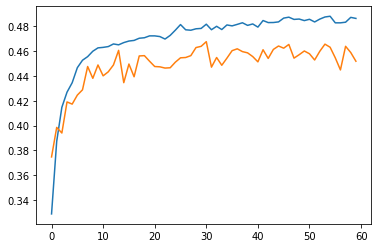

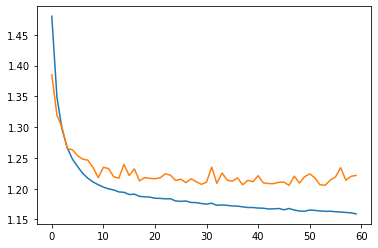

In [ ]:
# visualizing losses and accuracy
train_loss =  history.history['loss']
val_loss   =  history.history['val_loss']
train_acc  =  history.history['categorical_accuracy']
val_acc    =  history.history['val_categorical_accuracy']
xc         = range(60)

plt.figure()
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)

plt.figure()
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)


In [ ]:
preds = moonModel.evaluate(x = X_test, y = Y_test)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

2000/2000 [==============================] - 1s 268us/step

Loss = 1.2891657161712646
Test Accuracy = 0.4385


In [ ]:
def FullMoonModel(input_shape):
    """
    Implementation of the Model.

    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """


    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(input_shape)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(2, (1, 1), strides = (1, 1), name = 'conv0')(X_input)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    # Zero-Padding: pads the border of X_input with zeroes
    X = Flatten()(X)
    X = Dense(20, activation='relu', name='fc1')(X)
    X = Dense(10, activation='relu', name='fc2')(X)
    #X = Dense(5, activation='relu', name='fc3')(X)
    X = Dense(5, activation='relu', name='fc4')(X)
    X = Dense(5, activation='softmax', name='SoftMax')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='MoonModel')


    ### END CODE HERE ###

    return model

In [ ]:
def ScoreFullMoonModel(input_shape):
    """
    Implementation of the Model.

    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """


    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(input_shape)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(1, (1, 1), strides = (1, 1), name = 'conv0', weights=FullMoonModel.layers[0].get_weights())(X_input)
    X = Activation('relu')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='MoonModel')


    ### END CODE HERE ###

    return model

In [ ]:
fullmoonModel = FullMoonModel((18, 11, 4))
fullmoonModel.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["categorical_accuracy"])
#K.set_value(fullmoonModel.optimizer.lr, 0.0008)
fullhistory = fullmoonModel.fit(x = X_train, y = Y_train , epochs =60, batch_size =16 ,validation_data=(X_test,Y_test))

NameError: ignored

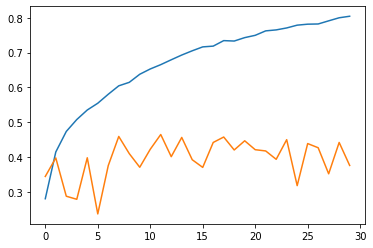

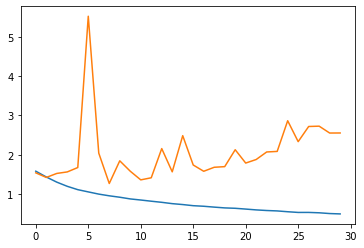

In [ ]:
# visualizing losses and accuracy
train_loss = fullhistory.history['loss']
val_loss   = fullhistory.history['val_loss']
train_acc  = fullhistory.history['categorical_accuracy']
val_acc    = fullhistory.history['val_categorical_accuracy']
xc         = range(30)

plt.figure()
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)

plt.figure()
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)


In [ ]:
preds = fullmoonModel.evaluate(x = X_test, y = Y_test)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

2000/2000 [==============================] - 0s 92us/step

Loss = 1.1714059858322143
Test Accuracy = 0.5015


In [ ]:
preds = fullmoonModel.evaluate(x = X_test, y = Y_test)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

2000/2000 [==============================] - 0s 83us/step

Loss = 1.1663485202789308
Test Accuracy = 0.487


In [ ]:
fullmoonModel.summary()

Model: "MoonModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 18, 11, 4)         0         
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 9, 64)         2368      
_________________________________________________________________
bn3 (BatchNormalization)     (None, 16, 9, 64)         256       
_________________________________________________________________
activation_2 (Activation)    (None, 16, 9, 64)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 9, 1)          65        
_________________________________________________________________
bn2 (BatchNormalization)     (None, 16, 9, 1)          4         
_________________________________________________________________
activation_3 (Activation)    (None, 16, 9, 1)          0 

In [ ]:
moonModel.summary()

Model: "MoonModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 18, 11, 4)         0         
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 9, 64)         2368      
_________________________________________________________________
bn3 (BatchNormalization)     (None, 16, 9, 64)         256       
_________________________________________________________________
activation_35 (Activation)   (None, 16, 9, 64)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 9, 1)          65        
_________________________________________________________________
bn2 (BatchNormalization)     (None, 16, 9, 1)          4         
_________________________________________________________________
activation_36 (Activation)   (None, 16, 9, 1)          0 

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0.]]
Boulder num. 844 and y = V0
IA prediction: V4
Prediction table: [5.2591931e-04 4.3000798e-03 3.5823733e-02 2.3542337e-01 7.2392684e-01]


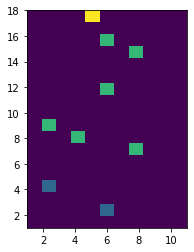

In [ ]:
# Example of a picture
index = 844#randint(1,Y_test.shape[0])
boulder = np.zeros((18,11))
for i in range(18):
    for j in range(11):
        boulder[i][j] = X_test[index][i][j][0]
plt.imshow(boulder,origin ='lower', extent=[1,11,1,18],aspect=0.80)

wtf = boulder*3
print(wtf)
"""
fig, ax = plt.subplots(1,1)
img = ax.imshow(boulder,origin ='lower')
x_label_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
ax.set_xticklabels(x_label_list)
fig.colorbar(img)
"""

print("Boulder num. "+str(index)+" and y = V" + str(np.squeeze(np.argmax(Y_test[index]))))
pred = moonModel.predict(np.array([X_test[index]]))
print("IA prediction: V"+str(np.argmax(pred)))
print("Prediction table: "+str(pred[0]))

146
276
433
646
938
940
1896
1987
2282
2490
Ratio: [349. 133. 134. 169. 293.]
Delta: [1078.  951.  385.   76.   10.]
Répartion V0: [349.  87.  43.  15.   4.]
Répartion V1: [160. 133.  99.  60.  10.]
Répartion V2: [ 73. 114. 134. 117.  70.]
Répartion V3: [ 35.  56. 111. 169. 145.]
Répartion V4: [  6.  16.  83. 118. 293.]


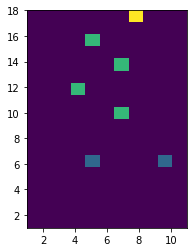

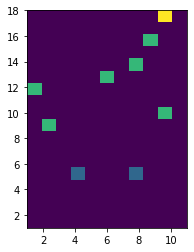

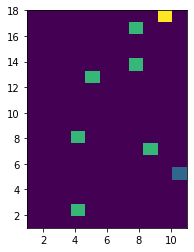

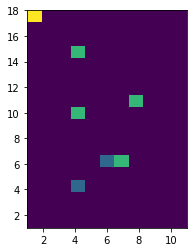

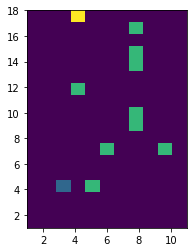

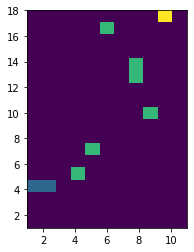

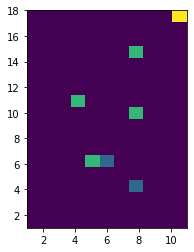

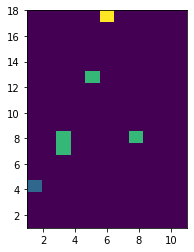

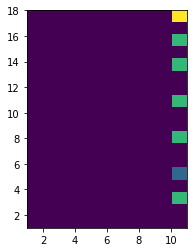

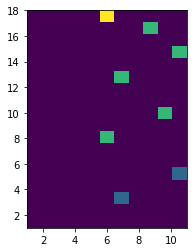

In [ ]:
def Ratiopredict(X_test, Y_test):
    Ratio = np.zeros(5)
    Delta = np.zeros(5)
    How = np.zeros((5,5))
    WTF = []
    for i in range(Y_test.shape[0]):
        prediction = np.argmax(fullmoonModel.predict(np.array([X_test[i]])))
        real = np.argmax(Y_test[i])
        if prediction == real:
            Ratio[np.argmax(Y_test[i])] +=1
        Delta[np.abs(real-prediction)] +=1
        if np.abs(real-prediction) == 4:
            boulder = np.zeros((18,11))
            for n in range(18):
                for j in range(11):
                    boulder[n][j] = X_test[i][n][j][0]
            print(i)
            WTF+=[boulder]
        How[real][prediction] +=1
    return (Ratio,Delta,How,WTF)
Ratio = Ratiopredict(X_test, Y_test)
print("Ratio: "+str(Ratio[0]))
print("Delta: "+str(Ratio[1]))
for i in range(5):
    print("Répartion V"+str(i)+": "+str(Ratio[2][i]))
for i in range(len(Ratio[3])):
    boulder = Ratio[3][i]
    plt.imshow(boulder,origin ='lower', extent=[1,11,1,18],aspect=0.80)
    plt.show()

In [ ]:
i = 0
for layer in fullmoonModel.layers:
    weights = layer.get_weights() # list of numpy arrays
    print("layer "+str(i)+"+ "+str(weights))
    i+=1

layer 0+ []
layer 1+ [array([[[[ 0.6891143 ],
         [-1.1616155 ],
         [ 0.31329113]]]], dtype=float32), array([0.10676739], dtype=float32)]
layer 2+ [array([1.0607228], dtype=float32), array([0.50693566], dtype=float32), array([0.10247792], dtype=float32), array([0.00579638], dtype=float32)]
layer 3+ []
layer 4+ []
layer 5+ [array([[ 0.16964228,  0.02350259,  0.12242583, ..., -0.09836903,
         0.18554695,  0.28592998],
       [ 0.26197314, -0.13906659, -0.08867616, ..., -0.00187392,
         0.13170955, -0.01347587],
       [ 0.13043723,  0.08117011,  0.20492032, ..., -0.0086288 ,
         0.17239894,  0.23287292],
       ...,
       [-0.10534927, -0.14547138,  0.24925362, ..., -0.1580884 ,
        -0.00096474, -0.19394359],
       [-0.16302434,  0.00688083, -0.10844149, ..., -0.01288568,
         0.11247648,  0.06623284],
       [ 0.0116481 , -0.20456591, -0.25448436, ..., -0.13436279,
         0.03356804,  0.33498228]], dtype=float32), array([-0.0258074 ,  0.11414712,  0

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.33333333, 1.        , 0.625     ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        ,

In [ ]:
model = FullMoonModel((18, 11, 3))
data = np.zeros((1,18,11,3))
data[0] = X_test[715]

layer_name = 'conv0'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(data)

[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -1.06810954  0.          0.          0.          0.        ]
 [ 0.          0.07615292  0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -0.31284964]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.94609407  0.          0.
   0.          1.12204868  0.  

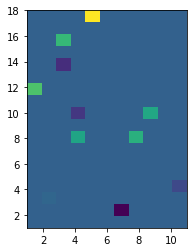

In [ ]:
intermediate_output.shape

# Example of a picture
index = 937#randint(1,Y_test.shape[0])

model = FullMoonModel((18, 11, 3))
data = np.zeros((1,18,11,3))
data[0] = X_test[index]

layer_name = 'conv0'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(data)

boulder = np.zeros((18,11))
for i in range(18):
    for j in range(11):
        boulder[i][j] = intermediate_output[0][i][j][0]
plt.imshow(boulder,origin ='lower', extent=[1,11,1,18],aspect=0.80)

wtf = boulder*3
print(wtf)
"""
fig, ax = plt.subplots(1,1)
img = ax.imshow(boulder,origin ='lower')
x_label_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
ax.set_xticklabels(x_label_list)
fig.colorbar(img)
"""

print("Boulder num. "+str(index)+" and y = V" + str(np.squeeze(np.argmax(Y_test[index]))))
pred = fullmoonModel.predict(np.array([X_test[index]]))
print("IA prediction: V"+str(np.argmax(pred)))
print("Prediction table: "+str(pred[0]))

[[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  2.5 0.  0.  0.  0. ]
 [0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  3. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  3.  0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.  0.  0.  0.  1.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0. ]]
Boulder num. 937 and y = V4
IA prediction: V0
Prediction table: [0.3600629  0.31720057 0.17354473 0.12981862 0.01937316]


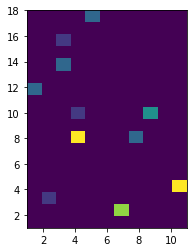

In [ ]:
# Example of a picture
index = 937#randint(1,Y_test.shape[0])
boulder = np.zeros((18,11))
for i in range(18):
    for j in range(11):
        boulder[i][j] = X_test[index][i][j][1]
plt.imshow(boulder,origin ='lower', extent=[1,11,1,18],aspect=0.80)

wtf = boulder*3
print(wtf)
"""
fig, ax = plt.subplots(1,1)
img = ax.imshow(boulder,origin ='lower')
x_label_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
ax.set_xticklabels(x_label_list)
fig.colorbar(img)
"""

print("Boulder num. "+str(index)+" and y = V" + str(np.squeeze(np.argmax(Y_test[index]))))
pred = fullmoonModel.predict(np.array([X_test[index]]))
print("IA prediction: V"+str(np.argmax(pred)))
print("Prediction table: "+str(pred[0]))

[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    1.875 0.    0.    0.    0.   ]
 [0.    2.25  0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.75 ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.375 0.    0.    0.    0.75  0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    3.    0.    0.    0.    0.    0.75  0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.375 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    3.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.

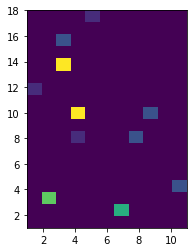

In [ ]:
# Example of a picture
index = 937#randint(1,Y_test.shape[0])
boulder = np.zeros((18,11))
for i in range(18):
    for j in range(11):
        boulder[i][j] = X_test[index][i][j][2]
plt.imshow(boulder,origin ='lower', extent=[1,11,1,18],aspect=0.80)

wtf = boulder*3
print(wtf)
"""
fig, ax = plt.subplots(1,1)
img = ax.imshow(boulder,origin ='lower')
x_label_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
ax.set_xticklabels(x_label_list)
fig.colorbar(img)
"""

print("Boulder num. "+str(index)+" and y = V" + str(np.squeeze(np.argmax(Y_test[index]))))
pred = fullmoonModel.predict(np.array([X_test[index]]))
print("IA prediction: V"+str(np.argmax(pred)))
print("Prediction table: "+str(pred[0]))

13
267
382
564
1188
1746
2153
2267
2382
3746
Ratio: [581. 229. 363. 251. 507.]
Delta: [1931. 1520.  473.   66.   10.]
Répartion V0: [581. 125.  93.  23.   8.]
Répartion V1: [233. 229. 218.  48.  16.]
Répartion V2: [ 77. 145. 363. 153.  80.]
Répartion V3: [ 17.  74. 233. 251. 247.]
Répartion V4: [  2.  10. 101. 166. 507.]


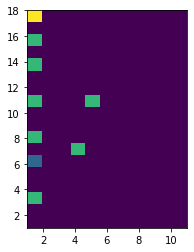

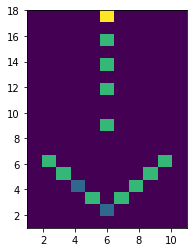

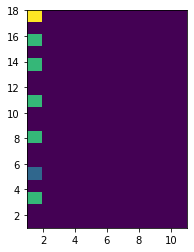

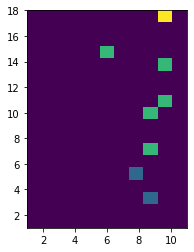

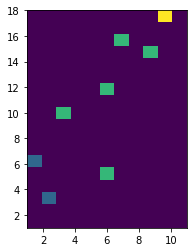

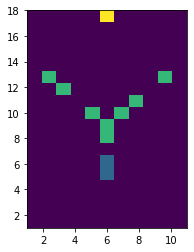

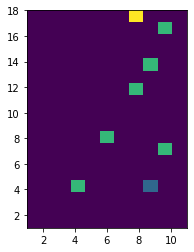

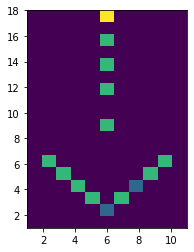

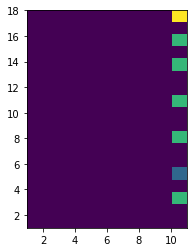

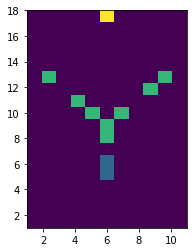

In [ ]:
def Ratiopredict(X_test, Y_test):
    Ratio = np.zeros(5)
    Delta = np.zeros(5)
    How = np.zeros((5,5))
    WTF = []
    for i in range(Y_test.shape[0]):
        prediction = np.argmax(moonModel.predict(np.array([X_test[i]])))
        real = np.argmax(Y_test[i])
        if prediction == real:
            Ratio[np.argmax(Y_test[i])] +=1
        Delta[np.abs(real-prediction)] +=1
        if np.abs(real-prediction) == 4:
            boulder = np.zeros((18,11))
            for n in range(18):
                for j in range(11):
                    boulder[n][j] = X_test[i][n][j][0]
            print(i)
            WTF+=[boulder]
        How[real][prediction] +=1
    return (Ratio,Delta,How,WTF)
Ratio = Ratiopredict(X_test, Y_test)
print("Ratio: "+str(Ratio[0]))
print("Delta: "+str(Ratio[1]))
for i in range(5):
    print("Répartion V"+str(i)+": "+str(Ratio[2][i]))
for i in range(len(Ratio[3])):
    boulder = Ratio[3][i]
    plt.imshow(boulder,origin ='lower', extent=[1,11,1,18],aspect=0.80)
    plt.show()